In [1]:
import pandas as pd
import warnings
import re
import requests, zipfile, io, os
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')

In [2]:
# download file from url, extract it and store it in the dest_folder
def download_and_extract(url, dest_folder):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall(dest_folder)

In [3]:
# define folders and urls
healthy_path = './healthy'
healthy_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip'
parkinson_path = './parkinson'
parkinson_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip'

In [4]:
download_and_extract(healthy_url, healthy_path)

In [5]:
download_and_extract(parkinson_url, parkinson_path)

In [6]:
# actual downloaded signals
healthy_signals = f'{healthy_path}/Signal/'
parkinson_signals = f'{parkinson_path}/Signal/'

In [7]:
# define Input and labels (0 = healthy, parkinson = 1)
X = []
y = []
seq = 100

In [8]:
# create dataset with sequence length

# healthy signals
for filename in os.listdir(healthy_signals):
  if re.search('sigDia', filename) is not None:
    df = pd.read_csv(healthy_signals + filename, sep='\s+', header=None, comment='#')
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy(copy=True))
      y.append(0)

# parkinson signals
for filename in os.listdir(parkinson_signals):
  if re.search('sigDia', filename) is not None:
    df = pd.read_csv(parkinson_signals + filename, sep='\s+', header=None, comment='#')
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy(copy=True))
      y.append(1) 


In [9]:
len(X)

28687

In [10]:
# convert lists to np arrays
X = np.array(X)
y = np.array(y)

In [11]:
X.shape

(28687, 100, 6)

In [12]:
y.shape

(28687,)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)


In [15]:
model = keras.models.Sequential([
keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 6)),
keras.layers.LSTM(128),
keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(32, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(1, activation="sigmoid")
])


In [16]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [17]:
checkpoint_filepath = "model.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
history = model.fit(X_train, y_train, epochs = 120, batch_size = 32, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

Epoch 1/120
718/718 [==============================] - 11s 15ms/step - loss: 0.5585 - accuracy: 0.7144 - val_loss: 0.5677 - val_accuracy: 0.7020
Epoch 2/120
718/718 [==============================] - 10s 14ms/step - loss: 0.5123 - accuracy: 0.7433 - val_loss: 0.4701 - val_accuracy: 0.7785
Epoch 3/120
718/718 [==============================] - 10s 14ms/step - loss: 0.5144 - accuracy: 0.7385 - val_loss: 0.7255 - val_accuracy: 0.6542
Epoch 4/120
718/718 [==============================] - 10s 14ms/step - loss: 0.5586 - accuracy: 0.7014 - val_loss: 0.9043 - val_accuracy: 0.6502
Epoch 5/120
718/718 [==============================] - 10s 14ms/step - loss: 0.5643 - accuracy: 0.6933 - val_loss: 0.5911 - val_accuracy: 0.6551
Epoch 6/120
718/718 [==============================] - 10s 14ms/step - loss: 0.5141 - accuracy: 0.7388 - val_loss: 0.4822 - val_accuracy: 0.7591
Epoch 7/120
718/718 [==============================] - 10s 14ms/step - loss: 0.5286 - accuracy: 0.7262 - val_loss: 0.6236 - val_ac

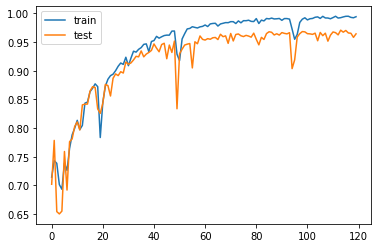

In [19]:
# 100
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [20]:
model.load_weights(checkpoint_filepath)
model.evaluate(X_valid, y_valid)

180/180 [==============================] - 1s 6ms/step - loss: 0.1169 - accuracy: 0.9709


[0.11689619719982147, 0.9708957672119141]

In [21]:
!ls

healthy  model.h5  parkinson  sample_data


In [22]:
from google.colab import files
files.download('model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>